# Training of Random Forest classifiers

In the following, we train different versions of the Rhapsody classifier and compare their accuracy. Each version is trained on the Integrated Dataset of human missense variants and evaluated through 10-fold cross-validation. 

More specifically, we considered:
* different subsets of features,
* different subsets of the training dataset,
* different classifier's hyperparameters

In [1]:
import sys, os
import pickle
import numpy as np
from glob import glob

In [2]:
# Insert here path to Rhapsody folder
sys.path.insert(0, '/home/lponzoni/Scratch/028-RHAPSODY-git/rhapsody') 

In [3]:
from rhapsody import *

## Importing the training dataset

The Integrated Dataset used for training is made available as a NumPy structured array containing all precomputed features, as well as true labels and other info (e.g. PDB lengths).

In [4]:
ID = pickle.load(open('Integrated_Dataset.pkl', 'rb'))

In [5]:
# array structure
ID.dtype.names

('SAV_coords',
 'Uniprot2PDB',
 'PDB_length',
 'true_label',
 'wt_PSIC',
 'Delta_PSIC',
 'SASA',
 'Delta_SASA',
 'BLOSUM',
 'GNM_MSF-chain',
 'GNM_MSF-reduced',
 'GNM_effectiveness-chain',
 'GNM_effectiveness-reduced',
 'GNM_sensitivity-chain',
 'GNM_sensitivity-reduced',
 'ANM_MSF-chain',
 'ANM_MSF-reduced',
 'ANM_effectiveness-chain',
 'ANM_effectiveness-reduced',
 'ANM_sensitivity-chain',
 'ANM_sensitivity-reduced',
 'stiffness-chain',
 'stiffness-reduced',
 'MBS-chain',
 'MBS-reduced',
 'entropy',
 'ranked_MI',
 'EVmut-DeltaE_epist',
 'EVmut-DeltaE_indep',
 'EVmut-wt_aa_cons',
 'EVmut-mut_aa_freq')

In [6]:
# each entry can be accessed by indexing
ID[0]

('Q96JB6 405 D A', 'Unable to map SAV to PDB', nan, 0, -0.924, 2.234, nan, nan, -2., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.469, 0.9847, -6.859, -2.213, 0.5493, 0.07133)

In [7]:
# size of the training dataset
len(ID)

92108

In [8]:
# number of entries with an associated PDB structure
len(ID[~np.isnan(ID['PDB_length'])])

28010

## Cross-validation with various classification schemes

We assess, through 10-fold cross-validation, the effect of considering different combinations of features and training datasets. 
In particular, we compare performances when using:
* different subsets of the training dataset, obtained by selecting those cases where PDB structures were larger than *n* residues
* 4 different feature sets, including one reproducing version 1 of the method (RAPSODY)
* **GNM** vs **ANM** features
* ENM features computed with and without the inclusion of *enviromental* effects (**reduced** vs **chain** model), i.e. the presence of other chains in the PDB structure


In [9]:
os.mkdir('data')

In [10]:
# this cell requires ~3.5 hours to complete

from prody import LOGGER
LOGGER.start('RF_training.log')

CV_summaries = {}

if os.path.isfile('data/CV-summaries.pkl'):
    print('A pickle containing precomputed training results have been found.')
    print('Please delete it if you wish to run the training again.')
else:
    for min_num_res in [0, 100, 150, 200, 300, 400, 500, 600]:
        # compute subset of the training dataset
        ID_subset = ID[ ~np.isnan(ID['PDB_length']) ]
        ID_subset = ID_subset[ ID_subset['PDB_length'] >= min_num_res ]
        
        # loop over different classification schemes
        for ENM in ['GNM', 'ANM']:
            for model in ['chain', 'reduced']:
                for version in ['v2', 'v2_noPfam', 'v2_EVmut', 'v1']:

                    # select feature set (+ true label)
                    if version == 'v2':
                        # full classifier
                        featset = ['true_label', 
                                   'wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   f'{ENM}_MSF-{model}',
                                   f'{ENM}_effectiveness-{model}',
                                   f'{ENM}_sensitivity-{model}',
                                   f'stiffness-{model}',
                                   'entropy', 'ranked_MI', 'BLOSUM']
                    elif version == 'v2_noPfam':
                        # reduced classifier
                        featset = ['true_label',
                                   'wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   f'{ENM}_MSF-{model}',
                                   f'{ENM}_effectiveness-{model}',
                                   f'{ENM}_sensitivity-{model}',
                                   f'stiffness-{model}',
                                   'BLOSUM']
                    elif version == 'v2_EVmut':
                        # full classifier + EVmutation epistatic score
                        featset = ['true_label',
                                   'wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   f'{ENM}_MSF-{model}',
                                   f'{ENM}_effectiveness-{model}',
                                   f'{ENM}_sensitivity-{model}',
                                   f'stiffness-{model}',
                                   'entropy', 'ranked_MI', 'BLOSUM',
                                   'EVmut-DeltaE_epist']
                    elif version == 'v1' and ENM == 'GNM' and model == 'chain':
                        # classifier as in version 1 of Rhapsody (RAPSODY)
                        # NB: RAPSODY used a combination of GNM/ANM features, which
                        # we reproduce here for the sake of comparison
                        featset = ['true_label', 
                                   'wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   'GNM_MSF-chain', 
                                   'ANM_effectiveness-chain', 
                                   'ANM_sensitivity-chain',
                                   'stiffness-chain']
                    else:
                        continue

                    if version == 'v1':
                        scheme = f'{min_num_res}-v1'
                    else:
                        scheme = f'{min_num_res}-{ENM}-{model}-{version}'
                        
                    LOGGER.info(f'CLASSIFICATION SCHEME: {scheme}')

                    # create folder
                    folder = f'data/clsf_scheme-{scheme}'
                    os.mkdir(folder)
                    
                    # train the classifier
                    clsf = trainRFclassifier(ID_subset[featset])

                    # store summary from cross-validation into a dictionary
                    CV_summaries[scheme] = clsf['CV summary']

                    # move figures into folder
                    for file in glob('*png'):
                        os.rename(file, os.path.join(folder, file))

                    # we'll only keep classifiers trained with the 150 min_num_res requirement
                    clsf_file = 'trained_classifier.pkl'
                    if min_num_res == 150:
                        os.rename(clsf_file, os.path.join(folder, clsf_file))
                    else:
                        os.remove(clsf_file)
                    
                    LOGGER.info('')
                    
    # store all cross-validation results into a pickle
    pickle.dump(CV_summaries, open('data/CV_summaries.pkl', 'wb'))

LOGGER.close('RF_training.log')

@> Logging into file: RF_training.log
@> Logging started at 2019-02-05 13:55:34.535024
@> CLASSIFICATION SCHEME: 0-GNM-chain-v2
@> 5955 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.840   OOB score = 0.817
@> CV iteration # 2:    ROC-AUC = 0.852   OOB score = 0.817
@> CV iteration # 3:    ROC-AUC = 0.839   OOB score = 0.818
@> CV iteration # 4:    ROC-AUC = 0.829   OOB score = 0.817
@> CV iteration # 5:    ROC-AUC = 0.841   OOB score = 0.818
@> CV iteration # 6:    ROC-AUC = 0.847   OOB score = 0.819
@> CV iteration # 7:    ROC-AUC = 0.844   OOB score = 0.819
@> CV iteration # 8:    ROC-AUC = 0.845   OOB score = 0.818
@> CV iteration # 9:    ROC-AUC = 0.860   OOB score = 0.818
@> CV iteration #10:    ROC-AUC = 0.851   OOB score = 0.819
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   22055
@> fraction of positives:   0.731
@> mean ROC-AUC:            0.845
@> mean OOB score: 

@> feature importances:
@>                 wt_PSIC: 0.186
@>              Delta_PSIC: 0.251
@>                    SASA: 0.099
@>           GNM_MSF-chain: 0.118
@> ANM_effectiveness-chain: 0.116
@>   ANM_sensitivity-chain: 0.109
@>         stiffness-chain: 0.121
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 
@> CLASSIFICATION SCHEME: 0-GNM-reduced-v2
@> 5978 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.842   OOB score = 0.813
@> CV iteration # 2:    ROC-AUC = 0.835   OOB score = 0.815
@> CV iteration # 3:    ROC-AUC = 0.852   OOB score = 0.813
@> CV iteration # 4:    ROC-AUC = 0.834   OOB score = 0.814
@> CV iteration # 5:    ROC-AUC = 0.841   OOB score = 0.814
@> CV iteration # 6:    ROC-AUC = 0.837   OOB score = 0.815
@> CV iteration # 7:    ROC-AUC = 0.834   OOB score = 0.815
@> CV iteration # 8:    ROC-AUC = 0.843   OOB score = 0.813
@> CV iteration # 9:    ROC-AUC = 

@>                 entropy: 0.114
@>               ranked_MI: 0.081
@>                  BLOSUM: 0.050
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.818
@> feature importances:
@>                 wt_PSIC: 0.148
@>              Delta_PSIC: 0.196
@>                    SASA: 0.077
@>           ANM_MSF-chain: 0.083
@> ANM_effectiveness-chain: 0.085
@>   ANM_sensitivity-chain: 0.078
@>         stiffness-chain: 0.089
@>                 entropy: 0.113
@>               ranked_MI: 0.081
@>                  BLOSUM: 0.050
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 
@> CLASSIFICATION SCHEME: 0-ANM-chain-v2_noPfam
@> 313 out of 28010 

@> Cross-validation summary:
@> training dataset size:   27662
@> fraction of positives:   0.714
@> mean ROC-AUC:            0.829
@> mean OOB score:          0.802
@> optimal cutoff*:         0.715 +/- 0.032
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.184
@>              Delta_PSIC: 0.230
@>                    SASA: 0.100
@>         ANM_MSF-reduced: 0.104
@> ANM_effectiveness-reduced: 0.108
@> ANM_sensitivity-reduced: 0.101
@>       stiffness-reduced: 0.115
@>                  BLOSUM: 0.057
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.803
@> feature importances:
@>                 wt_PSIC: 0.188
@>              Delta_PSIC: 0.227
@>                    SASA

@> CV iteration # 5:    ROC-AUC = 0.846   OOB score = 0.845
@> CV iteration # 6:    ROC-AUC = 0.848   OOB score = 0.847
@> CV iteration # 7:    ROC-AUC = 0.861   OOB score = 0.844
@> CV iteration # 8:    ROC-AUC = 0.864   OOB score = 0.846
@> CV iteration # 9:    ROC-AUC = 0.837   OOB score = 0.846
@> CV iteration #10:    ROC-AUC = 0.851   OOB score = 0.844
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   15533
@> fraction of positives:   0.781
@> mean ROC-AUC:            0.849
@> mean OOB score:          0.845
@> optimal cutoff*:         0.789 +/- 0.030
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.117
@>              Delta_PSIC: 0.146
@>                    SASA: 0.067
@>           GNM_MSF-chain: 0.075
@> GNM_effectiveness-chain: 0.074
@>   GNM_sensitivity-chain: 0.074
@>         stiffness-chain: 0.071
@>                 entropy: 0.089
@>               ranked_MI: 0.069
@>   

@> CLASSIFICATION SCHEME: 100-GNM-reduced-v2_EVmut
@> 10039 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.850   OOB score = 0.843
@> CV iteration # 2:    ROC-AUC = 0.838   OOB score = 0.843
@> CV iteration # 3:    ROC-AUC = 0.860   OOB score = 0.844
@> CV iteration # 4:    ROC-AUC = 0.853   OOB score = 0.843
@> CV iteration # 5:    ROC-AUC = 0.848   OOB score = 0.843
@> CV iteration # 6:    ROC-AUC = 0.851   OOB score = 0.844
@> CV iteration # 7:    ROC-AUC = 0.853   OOB score = 0.842
@> CV iteration # 8:    ROC-AUC = 0.830   OOB score = 0.843
@> CV iteration # 9:    ROC-AUC = 0.828   OOB score = 0.845
@> CV iteration #10:    ROC-AUC = 0.835   OOB score = 0.843
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   15533
@> fraction of positives:   0.781
@> mean ROC-AUC:            0.844
@> mean OOB score:          0.843
@> optimal cutoff*:         0.753 +/- 0.019
@> (* argmax of Y

@> Classifier training summary:
@> mean OOB score:          0.846
@> feature importances:
@>                 wt_PSIC: 0.117
@>              Delta_PSIC: 0.145
@>                    SASA: 0.068
@>           ANM_MSF-chain: 0.070
@> ANM_effectiveness-chain: 0.078
@>   ANM_sensitivity-chain: 0.072
@>         stiffness-chain: 0.074
@>                 entropy: 0.088
@>               ranked_MI: 0.068
@>                  BLOSUM: 0.041
@>      EVmut-DeltaE_epist: 0.178
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 
@> CLASSIFICATION SCHEME: 100-ANM-reduced-v2
@> 5071 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.845   OOB score = 0.812
@> CV iteration # 2:    ROC-AUC = 0.835   OOB score = 0.817
@> CV iteration # 3:    ROC-AUC = 0.866   OOB score = 0.814
@> CV iteration # 4:    ROC-AUC = 0.846   OOB score = 0.818
@> CV iteration # 5:    ROC-AUC = 0.835   OOB score = 0.815
@> CV iter

@>              Delta_PSIC: 0.200
@>                    SASA: 0.075
@>           GNM_MSF-chain: 0.088
@> GNM_effectiveness-chain: 0.082
@>   GNM_sensitivity-chain: 0.082
@>         stiffness-chain: 0.084
@>                 entropy: 0.108
@>               ranked_MI: 0.079
@>                  BLOSUM: 0.048
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.825
@> feature importances:
@>                 wt_PSIC: 0.153
@>              Delta_PSIC: 0.200
@>                    SASA: 0.075
@>           GNM_MSF-chain: 0.088
@> GNM_effectiveness-chain: 0.082
@>   GNM_sensitivity-chain: 0.083
@>         stiffness-chain: 0.084
@>                 entropy: 0.108
@>               ranked_MI: 0.078
@>                  B

@> Cross-validation summary:
@> training dataset size:   18775
@> fraction of positives:   0.732
@> mean ROC-AUC:            0.845
@> mean OOB score:          0.820
@> optimal cutoff*:         0.741 +/- 0.026
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.154
@>              Delta_PSIC: 0.204
@>                    SASA: 0.078
@>         GNM_MSF-reduced: 0.084
@> GNM_effectiveness-reduced: 0.077
@> GNM_sensitivity-reduced: 0.079
@>       stiffness-reduced: 0.084
@>                 entropy: 0.111
@>               ranked_MI: 0.080
@>                  BLOSUM: 0.049
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.820
@> feature importances:
@>                 wt_PSIC

@> CV iteration # 3:    ROC-AUC = 0.825   OOB score = 0.809
@> CV iteration # 4:    ROC-AUC = 0.836   OOB score = 0.808
@> CV iteration # 5:    ROC-AUC = 0.828   OOB score = 0.809
@> CV iteration # 6:    ROC-AUC = 0.844   OOB score = 0.808
@> CV iteration # 7:    ROC-AUC = 0.839   OOB score = 0.808
@> CV iteration # 8:    ROC-AUC = 0.830   OOB score = 0.808
@> CV iteration # 9:    ROC-AUC = 0.839   OOB score = 0.808
@> CV iteration #10:    ROC-AUC = 0.845   OOB score = 0.808
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   23180
@> fraction of positives:   0.711
@> mean ROC-AUC:            0.837
@> mean OOB score:          0.808
@> optimal cutoff*:         0.726 +/- 0.030
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.187
@>              Delta_PSIC: 0.233
@>                    SASA: 0.098
@>           ANM_MSF-chain: 0.105
@> ANM_effectiveness-chain: 0.110
@>   ANM_sensitivity-

@>       stiffness-reduced: 0.109
@>                  BLOSUM: 0.055
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 
@> CLASSIFICATION SCHEME: 150-ANM-reduced-v2_EVmut
@> 8916 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.856   OOB score = 0.848
@> CV iteration # 2:    ROC-AUC = 0.851   OOB score = 0.847
@> CV iteration # 3:    ROC-AUC = 0.843   OOB score = 0.847
@> CV iteration # 4:    ROC-AUC = 0.850   OOB score = 0.848
@> CV iteration # 5:    ROC-AUC = 0.853   OOB score = 0.847
@> CV iteration # 6:    ROC-AUC = 0.875   OOB score = 0.848
@> CV iteration # 7:    ROC-AUC = 0.870   OOB score = 0.847
@> CV iteration # 8:    ROC-AUC = 0.825   OOB score = 0.848
@> CV iteration # 9:    ROC-AUC = 0.816   OOB score = 0.851
@> CV iteration #10:    ROC-AUC = 0.842   OOB score = 0.848
@> ------------------------------------------------------------
@> Cross-validation summary:
@> trai

@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.852
@> feature importances:
@>                 wt_PSIC: 0.118
@>              Delta_PSIC: 0.141
@>                    SASA: 0.065
@>           GNM_MSF-chain: 0.074
@> GNM_effectiveness-chain: 0.079
@>   GNM_sensitivity-chain: 0.074
@>         stiffness-chain: 0.074
@>                 entropy: 0.093
@>               ranked_MI: 0.069
@>                  BLOSUM: 0.041
@>      EVmut-DeltaE_epist: 0.173
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 
@> CLASSIFICATION SCHEME: 200-v1
@> 206 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.843   OOB score = 0.807
@> CV iteration # 2:    ROC-AUC = 0.825   OOB scor

@>         GNM_MSF-reduced: 0.076
@> GNM_effectiveness-reduced: 0.070
@> GNM_sensitivity-reduced: 0.069
@>       stiffness-reduced: 0.074
@>                 entropy: 0.095
@>               ranked_MI: 0.071
@>                  BLOSUM: 0.041
@>      EVmut-DeltaE_epist: 0.171
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.851
@> feature importances:
@>                 wt_PSIC: 0.121
@>              Delta_PSIC: 0.143
@>                    SASA: 0.066
@>         GNM_MSF-reduced: 0.076
@> GNM_effectiveness-reduced: 0.070
@> GNM_sensitivity-reduced: 0.069
@>       stiffness-reduced: 0.075
@>                 entropy: 0.096
@>               ranked_MI: 0.071
@>                  BLOSUM: 0.042
@>      EVmut-Del

@> CV iteration # 8:    ROC-AUC = 0.837   OOB score = 0.823
@> CV iteration # 9:    ROC-AUC = 0.829   OOB score = 0.821
@> CV iteration #10:    ROC-AUC = 0.839   OOB score = 0.824
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   16784
@> fraction of positives:   0.745
@> mean ROC-AUC:            0.842
@> mean OOB score:          0.822
@> optimal cutoff*:         0.725 +/- 0.028
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.153
@>              Delta_PSIC: 0.197
@>                    SASA: 0.077
@>         ANM_MSF-reduced: 0.079
@> ANM_effectiveness-reduced: 0.084
@> ANM_sensitivity-reduced: 0.076
@>       stiffness-reduced: 0.087
@>                 entropy: 0.115
@>               ranked_MI: 0.081
@>                  BLOSUM: 0.050
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity pl

@> 
@> CLASSIFICATION SCHEME: 300-GNM-chain-v2_noPfam
@> 200 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.812   OOB score = 0.806
@> CV iteration # 2:    ROC-AUC = 0.818   OOB score = 0.807
@> CV iteration # 3:    ROC-AUC = 0.793   OOB score = 0.808
@> CV iteration # 4:    ROC-AUC = 0.826   OOB score = 0.806
@> CV iteration # 5:    ROC-AUC = 0.805   OOB score = 0.807
@> CV iteration # 6:    ROC-AUC = 0.800   OOB score = 0.808
@> CV iteration # 7:    ROC-AUC = 0.823   OOB score = 0.808
@> CV iteration # 8:    ROC-AUC = 0.813   OOB score = 0.806
@> CV iteration # 9:    ROC-AUC = 0.807   OOB score = 0.809
@> CV iteration #10:    ROC-AUC = 0.826   OOB score = 0.806
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   14659
@> fraction of positives:   0.744
@> mean ROC-AUC:            0.812
@> mean OOB score:          0.807
@> optimal cutoff*:         0.759 +/- 0.028
@> (* argmax of 

@> GNM_effectiveness-reduced: 0.080
@> GNM_sensitivity-reduced: 0.078
@>       stiffness-reduced: 0.084
@>                 entropy: 0.112
@>               ranked_MI: 0.084
@>                  BLOSUM: 0.055
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 
@> CLASSIFICATION SCHEME: 300-GNM-reduced-v2_noPfam
@> 221 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.811   OOB score = 0.809
@> CV iteration # 2:    ROC-AUC = 0.798   OOB score = 0.809
@> CV iteration # 3:    ROC-AUC = 0.813   OOB score = 0.807
@> CV iteration # 4:    ROC-AUC = 0.817   OOB score = 0.809
@> CV iteration # 5:    ROC-AUC = 0.798   OOB score = 0.808
@> CV iteration # 6:    ROC-AUC = 0.803   OOB score = 0.809
@> CV iteration # 7:    ROC-AUC = 0.834   OOB score = 0.807
@> CV iteration # 8:    ROC-AUC = 0.807   OOB score = 0.807
@> CV iteration # 9:    ROC-AUC = 0.804   OOB score = 0.808
@> CV iteration #10:  

@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.808
@> feature importances:
@>                 wt_PSIC: 0.185
@>              Delta_PSIC: 0.222
@>                    SASA: 0.107
@>           ANM_MSF-chain: 0.105
@> ANM_effectiveness-chain: 0.110
@>   ANM_sensitivity-chain: 0.103
@>         stiffness-chain: 0.109
@>                  BLOSUM: 0.059
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 
@> CLASSIFICATION SCHEME: 300-ANM-chain-v2_EVmut
@> 5749 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.861   OOB score = 0.853
@> CV iteration # 2:    ROC-AUC = 0.850   OOB score = 0.853
@> CV iteration # 3:    ROC-AUC = 0.810   OOB score = 0.856
@> CV iteration

@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.122
@>              Delta_PSIC: 0.141
@>                    SASA: 0.070
@>         ANM_MSF-reduced: 0.071
@> ANM_effectiveness-reduced: 0.076
@> ANM_sensitivity-reduced: 0.069
@>       stiffness-reduced: 0.073
@>                 entropy: 0.089
@>               ranked_MI: 0.069
@>                  BLOSUM: 0.044
@>      EVmut-DeltaE_epist: 0.177
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.854
@> feature importances:
@>                 wt_PSIC: 0.124
@>              Delta_PSIC: 0.136
@>                    SASA: 0.070
@>         ANM_MSF-reduced: 0.071
@> ANM_effectiveness-reduced: 0.076
@> ANM_sensitivity-reduced: 0

@> CV iteration # 6:    ROC-AUC = 0.809   OOB score = 0.812
@> CV iteration # 7:    ROC-AUC = 0.830   OOB score = 0.810
@> CV iteration # 8:    ROC-AUC = 0.831   OOB score = 0.810
@> CV iteration # 9:    ROC-AUC = 0.833   OOB score = 0.814
@> CV iteration #10:    ROC-AUC = 0.825   OOB score = 0.809
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   10006
@> fraction of positives:   0.754
@> mean ROC-AUC:            0.819
@> mean OOB score:          0.811
@> optimal cutoff*:         0.761 +/- 0.038
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.206
@>              Delta_PSIC: 0.237
@>                    SASA: 0.106
@>           GNM_MSF-chain: 0.115
@> ANM_effectiveness-chain: 0.114
@>   ANM_sensitivity-chain: 0.111
@>         stiffness-chain: 0.111
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> 

@> 2536 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.839   OOB score = 0.833
@> CV iteration # 2:    ROC-AUC = 0.834   OOB score = 0.829
@> CV iteration # 3:    ROC-AUC = 0.865   OOB score = 0.831
@> CV iteration # 4:    ROC-AUC = 0.830   OOB score = 0.835
@> CV iteration # 5:    ROC-AUC = 0.828   OOB score = 0.830
@> CV iteration # 6:    ROC-AUC = 0.849   OOB score = 0.833
@> CV iteration # 7:    ROC-AUC = 0.834   OOB score = 0.830
@> CV iteration # 8:    ROC-AUC = 0.822   OOB score = 0.833
@> CV iteration # 9:    ROC-AUC = 0.843   OOB score = 0.834
@> CV iteration #10:    ROC-AUC = 0.849   OOB score = 0.830
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   7630
@> fraction of positives:   0.773
@> mean ROC-AUC:            0.838
@> mean OOB score:          0.832
@> optimal cutoff*:         0.770 +/- 0.031
@> (* argmax of Youden's index)
@> feature importances:
@>            

@> feature importances:
@>                 wt_PSIC: 0.165
@>              Delta_PSIC: 0.179
@>                    SASA: 0.081
@>         ANM_MSF-reduced: 0.082
@> ANM_effectiveness-reduced: 0.090
@> ANM_sensitivity-reduced: 0.078
@>       stiffness-reduced: 0.084
@>                 entropy: 0.107
@>               ranked_MI: 0.079
@>                  BLOSUM: 0.053
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 
@> CLASSIFICATION SCHEME: 400-ANM-reduced-v2_noPfam
@> 175 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.806   OOB score = 0.819
@> CV iteration # 2:    ROC-AUC = 0.831   OOB score = 0.815
@> CV iteration # 3:    ROC-AUC = 0.827   OOB score = 0.820
@> CV iteration # 4:    ROC-AUC = 0.827   OOB score = 0.815
@> CV iteration # 5:    ROC-AUC = 0.832   OOB score = 0.817
@> CV iteration # 6:    ROC-AUC = 0.825   OOB score = 0.819
@> CV iteration # 7:    ROC-AUC = 0.809   

@> GNM_effectiveness-chain: 0.102
@>   GNM_sensitivity-chain: 0.099
@>         stiffness-chain: 0.101
@>                  BLOSUM: 0.061
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.819
@> feature importances:
@>                 wt_PSIC: 0.208
@>              Delta_PSIC: 0.221
@>                    SASA: 0.102
@>           GNM_MSF-chain: 0.106
@> GNM_effectiveness-chain: 0.102
@>   GNM_sensitivity-chain: 0.099
@>         stiffness-chain: 0.101
@>                  BLOSUM: 0.061
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 
@> CLASSIFICATION SCHEME: 500-GNM-chain-v2_EVmut
@> 2864 out of 6441 cases ignored with missing featur

@> mean ROC-AUC:            0.824
@> mean OOB score:          0.822
@> optimal cutoff*:         0.735 +/- 0.053
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.211
@>              Delta_PSIC: 0.218
@>                    SASA: 0.100
@>         GNM_MSF-reduced: 0.109
@> GNM_effectiveness-reduced: 0.098
@> GNM_sensitivity-reduced: 0.097
@>       stiffness-reduced: 0.106
@>                  BLOSUM: 0.060
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.823
@> feature importances:
@>                 wt_PSIC: 0.212
@>              Delta_PSIC: 0.216
@>                    SASA: 0.101
@>         GNM_MSF-reduced: 0.110
@> GNM_effectiveness-reduced: 0.098
@> GNM_sensitivity-

@> CV iteration # 7:    ROC-AUC = 0.845   OOB score = 0.862
@> CV iteration # 8:    ROC-AUC = 0.825   OOB score = 0.871
@> CV iteration # 9:    ROC-AUC = 0.869   OOB score = 0.866
@> CV iteration #10:    ROC-AUC = 0.891   OOB score = 0.867
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   3577
@> fraction of positives:   0.822
@> mean ROC-AUC:            0.851
@> mean OOB score:          0.866
@> optimal cutoff*:         0.804 +/- 0.056
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.149
@>              Delta_PSIC: 0.145
@>                    SASA: 0.065
@>           ANM_MSF-chain: 0.069
@> ANM_effectiveness-chain: 0.071
@>   ANM_sensitivity-chain: 0.068
@>         stiffness-chain: 0.065
@>                 entropy: 0.084
@>               ranked_MI: 0.071
@>                  BLOSUM: 0.044
@>      EVmut-DeltaE_epist: 0.169
@> -------------------------------------------------------

@>      EVmut-DeltaE_epist: 0.170
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 
@> CLASSIFICATION SCHEME: 600-GNM-chain-v2
@> 1507 out of 4645 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.830   OOB score = 0.843
@> CV iteration # 2:    ROC-AUC = 0.876   OOB score = 0.840
@> CV iteration # 3:    ROC-AUC = 0.838   OOB score = 0.841
@> CV iteration # 4:    ROC-AUC = 0.826   OOB score = 0.845
@> CV iteration # 5:    ROC-AUC = 0.888   OOB score = 0.841
@> CV iteration # 6:    ROC-AUC = 0.840   OOB score = 0.840
@> CV iteration # 7:    ROC-AUC = 0.880   OOB score = 0.838
@> CV iteration # 8:    ROC-AUC = 0.825   OOB score = 0.845
@> CV iteration # 9:    ROC-AUC = 0.774   OOB score = 0.842
@> CV iteration #10:    ROC-AUC = 0.877   OOB score = 0.839
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   3138
@> fraction of po

@> Classifier training summary:
@> mean OOB score:          0.824
@> feature importances:
@>                 wt_PSIC: 0.222
@>              Delta_PSIC: 0.241
@>                    SASA: 0.103
@>           GNM_MSF-chain: 0.107
@> ANM_effectiveness-chain: 0.112
@>   ANM_sensitivity-chain: 0.109
@>         stiffness-chain: 0.107
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 
@> CLASSIFICATION SCHEME: 600-GNM-reduced-v2
@> 1513 out of 4645 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.851   OOB score = 0.841
@> CV iteration # 2:    ROC-AUC = 0.825   OOB score = 0.841
@> CV iteration # 3:    ROC-AUC = 0.845   OOB score = 0.841
@> CV iteration # 4:    ROC-AUC = 0.804   OOB score = 0.846
@> CV iteration # 5:    ROC-AUC = 0.874   OOB score = 0.839
@> CV iteration # 6:    ROC-AUC = 0.841   OOB score = 0.840
@> CV iteration # 7:    ROC-AUC = 0.864   OOB score = 0.845
@> CV iteration # 8:    ROC

@>   ANM_sensitivity-chain: 0.078
@>         stiffness-chain: 0.078
@>                 entropy: 0.098
@>               ranked_MI: 0.083
@>                  BLOSUM: 0.051
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.842
@> feature importances:
@>                 wt_PSIC: 0.194
@>              Delta_PSIC: 0.180
@>                    SASA: 0.077
@>           ANM_MSF-chain: 0.080
@> ANM_effectiveness-chain: 0.083
@>   ANM_sensitivity-chain: 0.078
@>         stiffness-chain: 0.078
@>                 entropy: 0.097
@>               ranked_MI: 0.082
@>                  BLOSUM: 0.051
@> ------------------------------------------------------------
@> Feat. importance plot saved to feat_importances.png
@> 


@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   4499
@> fraction of positives:   0.761
@> mean ROC-AUC:            0.845
@> mean OOB score:          0.832
@> optimal cutoff*:         0.730 +/- 0.038
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.210
@>              Delta_PSIC: 0.217
@>                    SASA: 0.097
@>         ANM_MSF-reduced: 0.101
@> ANM_effectiveness-reduced: 0.112
@> ANM_sensitivity-reduced: 0.101
@>       stiffness-reduced: 0.103
@>                  BLOSUM: 0.058
@> ------------------------------------------------------------
@> Predictions distribution saved to predictions_distribution.png
@> Pathogenicity plot saved to pathogenicity_prob.png
@> ROC plot saved to ROC.png
@> ------------------------------------------------------------
@> Classifier training summary:
@> mean OOB score:          0.833
@> feature importances:
@>                 wt_PSIC: 0.2

In [12]:
# recover precomputed cross-validation results
CV_summaries = pickle.load(open('data/CV_summaries.pkl', 'rb'))

## Figures

In [13]:
os.mkdir('figures')

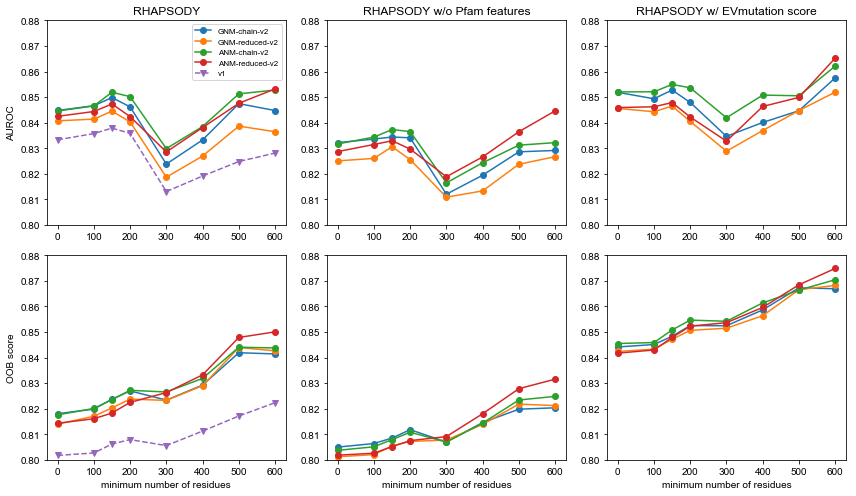

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(12,7))
fig.subplots_adjust(wspace=0.2)

ax[0,0].set_title('RHAPSODY')
ax[0,1].set_title('RHAPSODY w/o Pfam features')
ax[0,2].set_title('RHAPSODY w/ EVmutation score')
ax[0,0].set_ylabel('AUROC')
ax[1,0].set_ylabel('OOB score')
for j in range(3):
    ax[0,j].set_ylim([.80, .88])
    ax[1,j].set_ylim([.80, .88])
    ax[1,j].set_xlabel('minimum number of residues')

x = [0, 100, 150, 200, 300, 400, 500, 600]
for ENM in ['GNM', 'ANM']:
    for model in ['chain', 'reduced']:
        for i, version in enumerate(['v2', 'v2_noPfam', 'v2_EVmut']):
            scheme = f'{ENM}-{model}-{version}'
            AUC = [CV_summaries[f'{n}-{scheme}']['mean ROC-AUC'] for n in x]
            OOB = [CV_summaries[f'{n}-{scheme}']['mean OOB score'] for n in x]
            ax[0,i].plot(x, AUC, 'o-', label=scheme)
            ax[1,i].plot(x, OOB, 'o-', label=scheme)

AUC = [CV_summaries[f'{n}-v1']['mean ROC-AUC'] for n in x]
OOB = [CV_summaries[f'{n}-v1']['mean OOB score'] for n in x]
ax[0,0].plot(x, AUC, 'v--', label='v1')
ax[1,0].plot(x, OOB, 'v--', label='v1')

ax[0,0].legend(fontsize=8)

plt.tight_layout()
fig.savefig('figures/performances_comparison.png', dpi=300)

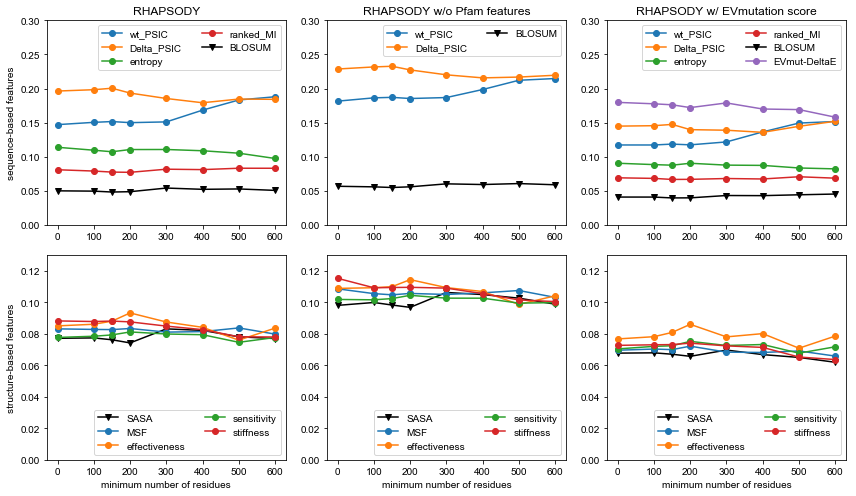

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(12,7))
fig.subplots_adjust(wspace=0.2)

featsets = {}
featsets['v2'] = ['wt_PSIC', 'Delta_PSIC', 'SASA', 'MSF', 
                  'effectiveness', 'sensitivity', 'stiffness', 
                  'entropy', 'ranked_MI', 'BLOSUM']
featsets['v2_noPfam'] = ['wt_PSIC', 'Delta_PSIC', 'SASA', 'MSF', 
                         'effectiveness', 'sensitivity', 'stiffness', 'BLOSUM']
featsets['v2_EVmut'] = featsets['v2'] + ['EVmut-DeltaE',]
SEQ_feats = ['wt_PSIC', 'Delta_PSIC', 'BLOSUM', 'entropy', 'ranked_MI', 'EVmut-DeltaE']

ax[0,0].set_title('RHAPSODY')
ax[0,1].set_title('RHAPSODY w/o Pfam features')
ax[0,2].set_title('RHAPSODY w/ EVmutation score')
ax[0,0].set_ylabel('sequence-based features')
ax[1,0].set_ylabel('structure-based features')
for j in range(3):
    ax[0,j].set_ylim([0, .3])
    ax[1,j].set_ylim([0, .13])
    ax[1,j].set_xlabel('minimum number of residues')

x = [0, 100, 150, 200, 300, 400, 500, 600]

for i, (version, featset) in enumerate(featsets.items()):
    for j,f in enumerate(featset):
        ss = [CV_summaries[f'{n}-ANM-chain-{version}']['feat. importance'][j] for n in x]
        if f in ['BLOSUM', 'SASA']:
            m = 'kv-'
        else:
            m = 'o-'
        if f in SEQ_feats:
            ax[0,i].plot(x, ss, m, label=f)
        else:
            ax[1,i].plot(x, ss, m, label=f)
            
for a in ax[0]:
    a.legend(loc='upper right', ncol=2)
for a in ax[1]:
    a.legend(loc='lower right', ncol=2)

plt.tight_layout()
fig.savefig('figures/feat_imp_comparison.png', dpi=300)

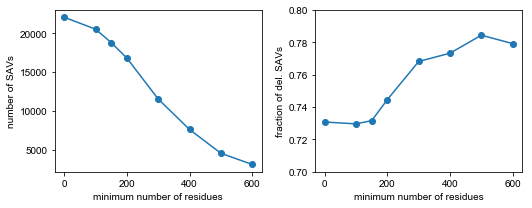

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5,3))
fig.subplots_adjust(wspace=0.2)

x = [0, 100, 150, 200, 300, 400, 500, 600]

y = np.array([CV_summaries[f'{n}-ANM-chain-v2']['dataset size'] for n in x])
ax1.plot(x, y, 'o-')
ax1.set_xlabel('minimum number of residues')
ax1.set_ylabel('number of SAVs')

y2 = np.array([CV_summaries[f'{n}-ANM-chain-v2']['dataset bias'] for n in x])
ax2.plot(x, y2, 'o-')
ax2.set_xlabel('minimum number of residues')
ax2.set_ylabel('fraction of del. SAVs')
ax2.set_ylim((0.7, 0.8))

plt.tight_layout()
fig.savefig('figures/stats.png', dpi=300)

## Summary

In [17]:
for version in ['v2', 'v2_noPfam', 'v2_EVmut', 'v1']:
    for min_num_res in [0, 100, 150, 200, 300, 400, 500, 600]:
        for ENM in ['GNM', 'ANM']:
            for model in ['chain', 'reduced']:

                if version == 'v1' and ENM == 'GNM' and model == 'chain':
                    scheme = f'{min_num_res}-v1'
                elif version != 'v1':
                    scheme = f'{min_num_res}-{ENM}-{model}-{version}'
                else:
                    continue

                s = CV_summaries[scheme]
               
                print(f'{version:<9} {min_num_res:3} {ENM} {model:7}:  ',
                      'size = {:5}  '.format(s['dataset size']),
                      'AUROC = {:5.3f}  '.format(s['mean ROC-AUC']),
                      'OOB = {:5.3f}'.format(s['mean OOB score']) )


v2          0 GNM chain  :   size = 22055   AUROC = 0.845   OOB = 0.818
v2          0 GNM reduced:   size = 22032   AUROC = 0.841   OOB = 0.814
v2          0 ANM chain  :   size = 22057   AUROC = 0.845   OOB = 0.818
v2          0 ANM reduced:   size = 22032   AUROC = 0.842   OOB = 0.814
v2        100 GNM chain  :   size = 20524   AUROC = 0.847   OOB = 0.820
v2        100 GNM reduced:   size = 20501   AUROC = 0.841   OOB = 0.817
v2        100 ANM chain  :   size = 20526   AUROC = 0.847   OOB = 0.820
v2        100 ANM reduced:   size = 20501   AUROC = 0.844   OOB = 0.816
v2        150 GNM chain  :   size = 18800   AUROC = 0.850   OOB = 0.824
v2        150 GNM reduced:   size = 18775   AUROC = 0.845   OOB = 0.820
v2        150 ANM chain  :   size = 18800   AUROC = 0.852   OOB = 0.824
v2        150 ANM reduced:   size = 18775   AUROC = 0.847   OOB = 0.818
v2        200 GNM chain  :   size = 16806   AUROC = 0.846   OOB = 0.827
v2        200 GNM reduced:   size = 16784   AUROC = 0.840   OOB 